# 3章 word2vec

#### テーマ：単語の分散表現について
* おさらい：「単語の分散表現（P67）」とは
  * 単語の意味を的確に捉えた単語のベクトルによる表現
  * 自然処理の分野での用語
* 期待される性質
  * コンパクトであること
  * 正確に指定できること
  * 関連性が判断しやすいこと
  * 定量化しやすいこと
  * 理にかなっていること
* 表現形式：密な固定長ベクトル（多くが0でない実数値で表現されること）
* 分散表現を得るための方法
  * カウントベースの手法
    * 周囲の単語の頻度によって単語を表現
    * 単語の共起行列を作り，それを特異値分解(SVD)して密なベクトル表現を得る
  * 推論ベースの手法
    * 推論問題を繰り返し解くことで学習し，コンテキストから各単語の出現確率を出力するモデルを生成する

## 3.1 推論ベースの手法とニューラルネットワーク
### 3.1.1 カウントベースの手法の問題点
* 大規模なコーパスでは語彙数が巨大になり，共起行列も巨大になる
  * 英語の語彙数は100万語を超えると言われる
  * その場合の共起行列は100万×100万
  * SVDは$O(n^3)$の計算量となるため，現実的ではない
* 推論ベースの特徴
  * ミニバッチで学習
    * 大抵の計算機で計算が実施できる
    * 並列化が容易で学習全体の高速化が可能
  * 語彙に新しい単語を追加する場合でもパラメータの再学習が可能
    * それまでの学習データを初期値として再学習して分散表現を更新できる
  * 分散表現が単語の類似性に加えて複雑な単語間のパターンも捉えることができる
    * 類推問題(例：king-man+woman=queen)を解くことができる
    * カウントベースの手法では単語間の類似性が主
  * 精度的にはカウントベース手法との優劣はつけられないとの報告がある
    * [Improving Distributional Similarity
with Lessons Learned from Word Embeddings](http://www.aclweb.org/anthology/Q15-1016)

### 3.1.2 推論ベースの手法の概要
* 推論ベースの手法で行うこと：「推論問題」を解くこと，および，そのために学習すること
  * 推論問題：周囲の単語（コンテキスト）が与えられた時にその間にどういう単語が出現するかを推論する
* 推論問題を繰り返し解くことで，単語の出現パターンを学習する
* 得られるモデルは，コンテキストを入力として与えた時に各単語の出現確率を出力するモデルとなる

### 3.1.3 ニューラルネットワークにおける単語の処理方法
* 単語を表現する方法の一つして「one-hot表現（one-hotベクトル）」がある
  * one-hotの説明は省略
* 手順
  1. コーパスに含まれる単語にIDを付与する
  1. IDからその単語に対するone-hot表現に変換する
    * one-hotのベクトル長は語彙数(単語IDの数)に固定される
    * コーパスの大きさによらない
    * ニューラルネットワークの入力層のニューロン数はこのサイズになる

#### 例（コーパス："You say goodbye and I say hello."）

| word    |ID| one-hot |
|---------|--|---------|
| you     | 0| 1000000 |
| say     | 1| 0100000 |
| goodbye | 2| 0010000 |
| and     | 3| 0001000 |
| I       | 4| 0000100 |
| hello   | 5| 0000010 |
| .       | 6| 0000001 |

#### 全結合層による表現

* one-hotで表現した単語は，レイヤを重ねることで処理を行うことができる
  * 例えばバイアスを用いない全結合層(単純に行列の積として表現される)

In [79]:
import numpy as np

# 単語IDが0の単語を one-hot で表現し，全結合層によって変換する例
# 今後ミニバッチを使うことを見越して c は2次元配列にしている
c = np.array([[1,0,0,0,0,0,0]]) # 入力(one-hot)
W = np.random.randn(7,3)        # 重み(標準正規分布に従ってランダムに生成)
h = np.dot(c, W)                # 中間ノード
print(h)

[[ 0.12119661 -1.25299626 -0.89137936]]


In [78]:
import numpy as np

# 行列積のレイヤ
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

# MatMulレイヤを使って変換する例
c = np.array([[1,0,0,0,0,0,0]]) # 入力
W = np.random.randn(7,3)        # 重み
layer = MatMul(W)
h = layer.forward(c)            # 中間ノード
print(h)


[[-1.50928377 -2.90430582 -1.996445  ]]


## 3.2 シンプルな word2vec
* ニューラルネットワークを使用して（コンテキストから各単語の出現確率を出力する）モデルを設計する
* モデルとしてCBOW(continuous bag-of-words)を使う
### 3.2.1 CBOWモデルの推論処理
* CBOWモデルはコンテキスト(周辺の単語)からターゲット(中央の単語)を推論するためのニューラルネットワーク
  * 入力はコンテキスト，つまり(one-hot表現で著された)単語のリスト
  * コンテキストとして何語を考えるかで入力層が変わってくる．ここでは2つを考える
  * 中間層の値は各入力層と重みとの行列積の平均をとる
    * **この重みが単語の分散表現となる**
    * **中間層のニューロン数を入力層よりも少なくする**．こうすることで密な表現が得られることになる．
    * 入力層から中間層への変換を「エンコード」と呼ぶ
  * 中間層から全結合層を経て出力層が計算される．これは行列積の計算に相当する
    * 中間層から出力層への変換を「デコード」と呼ぶ
  * 出力層は単語の語数だけのニューロンからなり，その値が高いほど高い出現確率を表す．Softmax関数を適用することで確率として解釈される値も得られる
* 学習を重ねることでコンテキストから出現する単語をうまく推測できるようになる
  * 得られたベクトルには単語の意味もエンコードされる

In [77]:
import numpy as np

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

# 入力層の2つの単語
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 重み行列
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# MatMulレイヤ
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)    # 2つの入力層はレイヤを共有する
out_layer = MatMul(W_out)

# 推論処理
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h) # スコア(Softmax適用前）

print(s)

[[ 0.32324315 -0.34171576 -0.01580541 -0.01017029 -0.19490854  0.01232151
  -0.13027292]]


### 3.2.2 CBOWモデルの学習
* これまでのCBOWモデルでは出力層で各単語のスコアを出力したが，これにSoftmaxを適用することで確率を得ることができる
  * CBOWモデルはコーパスにおける単語の出現パターンを学ぶだけなので，**コーパスが変われば単語の分散表現も変わる**
* 学習においては，Softmax関数の出力と教師ラベルとから交差エントロピー誤差を求め，それを損失として学習を行う

### 3.2.3 word2vecの重みと分散表現
* word2vecで使用するネットワークには入力側と出力側とで2つの重みがある
* どちらも単語の分散表現が格納しているが，どちらを用いるべきか
* word2vec(特に skip-gramモデル)では**入力側のみを使う**のがポピュラー

## 3.3 学習データの準備
### 3.3.1 コンテキストとターゲット
* コーパスからコンテキストとターゲットとを自動生成する

In [129]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .') # ピリオドも分割するため
    words = text.split(' ') # 空白で分割

    word_to_id = {}
    id_to_word = {}
    for word in words: # 単語ごとに
        if word not in word_to_id: # 含まれていなければ
            new_id = len(word_to_id) # IDを付与(0スタート)
            word_to_id[word] = new_id # (単語, ID)の組を辞書に登録
            id_to_word[new_id] = word # (ID, 単語)の組を辞書に登録

    # 元のテキストをIDの並びに置き換えたものをコーパスとする
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

def do_preprocess(text, corpus, word_to_id, id_to_word):
    corpus, word_to_id, id_to_word = preprocess(text)
    print("corpus = {c}".format(c=corpus))
    print("id_to_word = {itw}".format(itw=id_to_word))
    
    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
do_preprocess(text, corpus, word_to_id, id_to_word)

corpus = [0 1 2 3 4 1 5 6]
id_to_word = {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


(array([0, 1, 2, 3, 4, 1, 5, 6]),
 {'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0},
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'})

In [130]:
def create_contexts_target(corpus, window_size=1):
    '''コーパスからターゲットとコンテキストのリストをそれぞれ生成する

    :param corpus: 元のテキストをIDの並びに置き換えたもの(単語IDのNumPy配列)
    :param window_size: ターゲット周囲の何語をコンテキストにするかのサイズ
    :return: ターゲット(ID)のリストおよびコンテキストのリスト(共にNumPy配列)
    '''
    # 両端はターゲットにできないのでそれを除く部分をターゲットに設定
    target = corpus[window_size:-window_size]
    contexts = []

    # ターゲットとなる単語それぞれに対するコンテキストをかき集める
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # -window_size, ...　, 0, ... , window_size の範囲で
        for t in range(-window_size, window_size + 1):
            if t == 0: # 0の場合を除く
                continue
            # ターゲット(idx)の周囲の単語(idx+t)をcsに追加
            cs.append(corpus[idx + t])
        # ターゲット(idx)のコンテキスト(cs)をcontexts に追加
        contexts.append(cs)

    return np.array(contexts), np.array(target)

def do_create_contexts_target(corpus, contexts, target):
    
    # corpusからcontexts とtargetを生成する
    contexts, target = create_contexts_target(corpus, window_size=1)

    print("contexts = {ctx}".format(ctx=contexts))
    print("target = {t}".format(t=target))
    
    return contexts, target

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = do_preprocess(text, corpus, word_to_id, id_to_word)
contexts, target = do_create_contexts_target(corpus, contexts, target)

corpus = [0 1 2 3 4 1 5 6]
id_to_word = {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
contexts = [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target = [1 2 3 4 1 5]


In [48]:
# 配列の動作確認
test_arr = np.array([1, 2, 3, 4, 5, 6])
test_target = test_arr[1:-1]
print(test_target)

[2 3 4 5]


In [62]:
# rangeの動作確認
test_winsize = 1
test_corpsize = 6
for i in range(test_winsize, test_corpsize-test_winsize):
    print("i:{i}".format(i=i))
    for t in range(-test_winsize, test_winsize+1):
        print(" t:{t}".format(t=t))
    print("")

i:1
 t:-1
 t:0
 t:1

i:2
 t:-1
 t:0
 t:1

i:3
 t:-1
 t:0
 t:1

i:4
 t:-1
 t:0
 t:1



### 3.3.2 one-hot 表現への変換

In [137]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換

    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''

    # N:コーパスの語数
    print("corpus.shape={s}".format(s=corpus.shape))
    N = corpus.shape[0]
    print("N={n}".format(n=N))

    if corpus.ndim == 1:
        # サイズが N行 vocab_size列で，値が全て0の配列を作る
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)

        # idx行 word_id列を1にする
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        print("C={c}".format(c=C))
        # サイズが(N,C,vocan_size)で値が全て0の配列を作る
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        
        # (idx_0, idx_1, word_id) の値を1にする
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot

def do_convert_one_hot(contexts, target):
    # 単語ID表現をone-hotに変換する
    vocab_size = len(word_to_id)
    target = convert_one_hot(target, vocab_size)
    contexts = convert_one_hot(target, vocab_size)
    
    print("contexts = \n{ctx}".format(ctx=contexts))
    print("target = \n{t}".format(t=target))
    
    return contexts, target


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = do_preprocess(text, corpus, word_to_id, id_to_word)
contexts, target = do_create_contexts_target(corpus, contexts, target)
contexts, target = do_convert_one_hot(contexts, target)

corpus = [0 1 2 3 4 1 5 6]
id_to_word = {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
contexts = [[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target = [1 2 3 4 1 5]
corpus.shape=(6,)
N=6
corpus.shape=(6, 7)
N=6
C=7
contexts = 
[[[1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]


## 3.4 CBOWモデルの実装

In [19]:
class SimpleCBOW:
    # 初期化
    # vocab_size: 語彙数
    # hidden_size: 隠れ層のニューロン数
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化(重みは浮動小数点数の値をとる)
        # randn により標準正規分布に従ってランダムに初期値を生成
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 3.4.1 学習コードの実装

In [140]:
# ソフトマックス関数
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [138]:
# 交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [141]:
# SoftmaxWithLossレイヤ
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [142]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)



In [43]:
import time
import numpy
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()



In [44]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads



corpus.shape=(6,)
N=6
corpus.shape=(6, 2)
N=6
C=2
| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | t

| epoch 185 |  iter 1 / 2 | time 0[s] | loss 1.27
| epoch 186 |  iter 1 / 2 | time 0[s] | loss 1.34
| epoch 187 |  iter 1 / 2 | time 0[s] | loss 1.31
| epoch 188 |  iter 1 / 2 | time 0[s] | loss 1.27
| epoch 189 |  iter 1 / 2 | time 0[s] | loss 1.30
| epoch 190 |  iter 1 / 2 | time 0[s] | loss 1.36
| epoch 191 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 192 |  iter 1 / 2 | time 0[s] | loss 1.33
| epoch 193 |  iter 1 / 2 | time 0[s] | loss 1.31
| epoch 194 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 195 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 196 |  iter 1 / 2 | time 0[s] | loss 1.28
| epoch 197 |  iter 1 / 2 | time 0[s] | loss 1.31
| epoch 198 |  iter 1 / 2 | time 0[s] | loss 1.28
| epoch 199 |  iter 1 / 2 | time 0[s] | loss 1.28
| epoch 200 |  iter 1 / 2 | time 0[s] | loss 1.33
| epoch 201 |  iter 1 / 2 | time 0[s] | loss 1.27
| epoch 202 |  iter 1 / 2 | time 0[s] | loss 1.14
| epoch 203 |  iter 1 / 2 | time 0[s] | loss 1.30
| epoch 204 |  iter 1 / 2 | time 0[s] | loss 1.27


| epoch 357 |  iter 1 / 2 | time 0[s] | loss 1.13
| epoch 358 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 359 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 360 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 361 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 362 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 363 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 364 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 365 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 366 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 367 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 368 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 369 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 370 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 371 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 372 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 373 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 374 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 375 |  iter 1 / 2 | time 0[s] | loss 1.00
| epoch 376 |  iter 1 / 2 | time 0[s] | loss 0.99


| epoch 557 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 558 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 559 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 560 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 561 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 562 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 563 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 564 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 565 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 566 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 567 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 568 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 569 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 571 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 572 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 573 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 574 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 575 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 576 |  iter 1 / 2 | time 0[s] | loss 0.93


| epoch 839 |  iter 1 / 2 | time 1[s] | loss 0.99
| epoch 840 |  iter 1 / 2 | time 1[s] | loss 0.89
| epoch 841 |  iter 1 / 2 | time 1[s] | loss 0.88
| epoch 842 |  iter 1 / 2 | time 1[s] | loss 0.85
| epoch 843 |  iter 1 / 2 | time 1[s] | loss 0.89
| epoch 844 |  iter 1 / 2 | time 1[s] | loss 0.87
| epoch 845 |  iter 1 / 2 | time 1[s] | loss 1.02
| epoch 846 |  iter 1 / 2 | time 1[s] | loss 0.71
| epoch 847 |  iter 1 / 2 | time 1[s] | loss 0.89
| epoch 848 |  iter 1 / 2 | time 1[s] | loss 0.88
| epoch 849 |  iter 1 / 2 | time 1[s] | loss 0.75
| epoch 850 |  iter 1 / 2 | time 1[s] | loss 0.85
| epoch 851 |  iter 1 / 2 | time 1[s] | loss 0.99
| epoch 852 |  iter 1 / 2 | time 1[s] | loss 0.90
| epoch 853 |  iter 1 / 2 | time 1[s] | loss 0.76
| epoch 854 |  iter 1 / 2 | time 1[s] | loss 0.98
| epoch 855 |  iter 1 / 2 | time 1[s] | loss 0.76
| epoch 856 |  iter 1 / 2 | time 1[s] | loss 0.96
| epoch 857 |  iter 1 / 2 | time 1[s] | loss 0.87
| epoch 858 |  iter 1 / 2 | time 1[s] | loss 0.92


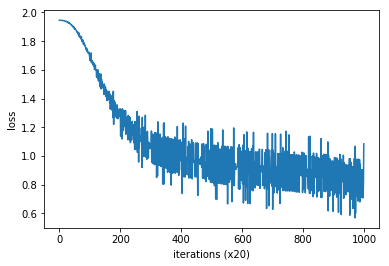

you [-1.1448408  1.154443  -1.1890558  1.1675558  1.2287627]
say [ 1.1712828 -1.1685073  1.2199197 -1.1945546 -1.0329347]
goodbye [-0.7703358   0.7808129  -0.72636896  0.7417283   0.73464614]
and [ 1.0438137 -1.1115834  0.7991398 -1.0349817 -1.5849347]
i [-0.76234543  0.7868732  -0.74084765  0.7248235   0.7560703 ]
hello [-1.1322765  1.1411966 -1.1688336  1.1920581  1.2297972]
. [ 0.9425348  -0.89114755  1.3157017  -1.0557013   0.3425734 ]


In [143]:
# これまでのまとめ

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# テキストからコーパスを作成
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# コーパスからターゲットおよびコンテキスト（いずれもone-hot表現）を生成
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOWモデルの生成
model = SimpleCBOW(vocab_size, hidden_size)

# 学習用クラスの生成(最適化手法：Adam)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習
trainer.fit(contexts, target, max_epoch, batch_size)
# 結果の表示
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])



## 3.5 word2vecに関する補足
### 3.5.1 CBOWモデルと確率

#### 確率の表記について
* 確率の表現
  * $P(A)$　：Aという事象が起こる確率
  * $P(A,B)$　：AとBが同時に起こる確率（**同時確率**）
  * $P(A \mid B)$　：Bが与えられた時にAが起こる確率(**事後確率**)

#### CBOWの確率表現

CBOWをモデル化すると次式で表現できる
* 「コンテキスト $w_{t-1}$ と $w_{t+1}$ が与えられた時にターゲット $w_t$ が起こる確率」

$$P(w_t \mid w_{t-1}w_{t+1})$$

CBOWモデルの損失関数を「交差エントロピー誤差」を用いて導出する

交差エントロピー誤差

$$L = -\sum_{k}t_k\log{y_k}$$

ここで，
* $y_k$：$k$ 番目に対応する事象が起こる確率 $P(w_k \mid w_{k-1}w_{k+1})$
* $t_k$：教師ラベル(one-hot表現の場合は (0,0,...,0,1,0,...,0)のような形)

$t_k$ がone-hotベクトルで表現され，k番目の要素だけ1でそれ以外は0であるため，それを考慮すると，$y_k$のk番目の要素だけが使われることになるため，次のようになる

**（上の交差エントロピー誤差では教師ラベルの記号に$t$を使っているため$k$番目の要素に注目しているが，下の式では$t$番目の要素$y_t$を取り出す話にさりげなく変わっていることに注意すること）**

$$L = -\log{P(w_t \mid w_{t-1}, w_{t+1})}$$

つまり，CBOWモデルの損失関数は確率$P(w_t \mid w_{t-1}w_{t+1})$に対して $\log$ をとり，負号をつけたものになる
* **負の対数尤度(negative log likelihood)**という

これをコーパス全体に拡張すると次のようになる

$$L = -\frac{1}{T}\sum_{t=1}^{T}\log{P(w_t \mid w_{t-1},w_{t+1})}$$

#### CBOWモデルの学習

* CBOWモデルの学習で行うことは，上記の損失関数を小さくすること
* 学習の結果得られる重みパラメータが単語の分散表現となる
  * 単語がone-hotで表現されることからIDがtの単語は行列のt行目だけを抜き出すことになるという点に注意する

### 3.5.2 skip-gram モデル
#### CBOWモデルとski-gramモデル
* CBOWモデルはコンテキスト(周囲の単語)からターゲット(中央の単語)を推測する
* skip-gramはターゲットからコンテキストを推測する

#### skip-gram モデルの構造
* 入力層は一つ
* 出力がコンテキストの数だけ存在
  * 損失をそれぞれのコンテキストの分だけ計算する
    * コンテキストが4つからなるならば4つの損失を計算する
  * それぞれの損失の和を最終的な損失とする

#### 確率表記
skip-gram をモデル化すると次式で表現できる
* つまり「$w_t$が与えられた時に$w_{t-1}$と$w_{t+1}$とが同時に起こる確率」

$$P(w_{t-1},w_{t+1} \mid w_t)$$

skip-gramモデルではコンテキストの単語間に関連性がない(条件付き独立)と仮定する

$$P(w_{t-1}m w_{t+1} \mid w_t) = P(w_{t-1} \mid w_t)P(w_{t+1} \mid w_t)$$

これを交差エントロピー誤差に適用して損失関数を導出する

$$L = -\log{P(w_{t-1},w_{t+1}\mid w_t)}$$

$$ = -\log{P(w_{t-1}\mid w_t)P(w_{t+1}\mid w_t)}$$

$$ = -(\log{P(w_{t-1}\mid w_t)}+\log{P(w_{t+1}\mid w_t)})$$

skip-gramモデルの損失関数は全ての $t$ に対するコンテキストの損失を合計したものになるため，次のようになる

$$L = -\frac{1}{T}\sum_{t=1}^{T}(\log{P(w_{t-1}\mid w_t)}+\log{P(w_{t+1}\mid w_t)})$$

#### CBOWとskip-gram
* 手順の違い
  * skip-gramはコンテキストの数だけ推論して損失関数を求める．そして総和を計算する
  * CBOWは一つのターゲットの損失を求める
* どちらを使うべきか：skip-gram
  * 単語の分散表現の精度で skip-gram の方が良い結果を得られる
  * コーパスが大規模になるにつ低頻出単語や類推問題の性能でskip-gramの方が優れる
  * 学習速度ではCBOWが高速．skip-gramは損失をコンテキストの数だけ求める必要があるため

### 3.5.3 カウントベース v.s. 推論ベース
* 両者の比較については[3.1.1](Chapter%203.ipynb#3.1.1-カウントベースの手法の問題点)を参照
* 両者の関連性
  * skip-gram と Negative Sampling を利用したモデルは，コーパス全体の共起行列に対して若干の処理および特殊な行列分解を施したものに等しい
  * 推論ベースとカウントベースの両手法を融合させた手法も提案されている
    * [GloVe](https://nlp.stanford.edu/projects/glove/)：コーパス全体の統計データの情報を損失関数に取り入れミニバッチ学習を行う

## 3.6 まとめ
* これまでやろうとしてきたことは「単語の分散表現」を得ること
* 分散表現を得るための手法としてカウントベースの手法と推論ベースの手法がある
  * どちらも「分布仮説」に基づき「単語の共起性」をいかにモデル化するかという点を問題にしている
  * 推論ベースの手法は重みの再学習ができる．そのため単語の分散表現の更新や追加を効率的に行うことができる
* 推論ベースの手法は推測することを目標とし，その副産物として単語の分散表現が得られる
* 推論ベースの手法としてword2vecがある．
  * word2vecはTomas Mikolov氏による一連の論文によって提案された
    * [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781)
    * [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546)
  * word2vecの有用性は自然言語処理のタスクで示されてきた

* word2vecにはskip-gramモデルとCBOWモデルとがある
  * word2vecのモデルはシンプルな2層のニューラルネットワークで構成される
  * 両者の違い
    * CBOWモデルは複数の単語（コンテキスト）から一つの単語（ターゲット）を推測する
    * skip-gramモデルは一つの単語（ターゲット）から複数の単語（コンテキスト）を推測する
  * 本章ではword2vecのCBOWモデルと呼ばれるニューラルネットワークについて説明
    * CBOWモデルの構築には MatMulレイヤとSoftmax with Lossレイヤを使った
    * CBOWモデルを小規模なコーパスで学習できることを確認した
* 次章
  * 現状のCBOWモデルは処理効率の点で問題があるため，モデルを改良する
  * word2vecの重要性，特に転移学習の有用性，について扱う
